# Redispatch Example

In this example, we compare a 2-stage market with an initial market clearing in two bidding zones with flow-based market coupling and a subsequent redispatch market (incl. curtailment) to an idealised nodal pricing scheme.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import pypsa
from pypsa.descriptors import get_switchable_as_dense as as_dense

## Load example network

In [2]:
o = pypsa.examples.scigrid_de()
o.lines.s_max_pu = 0.7
o.lines.loc[["316", "527", "602"], "s_nom"] = 1715
o.set_snapshots([o.snapshots[12]])

INFO:pypsa.network.io:Retrieving network data from https://github.com/PyPSA/PyPSA/raw/v0.35.0/examples/networks/scigrid-de/scigrid-de.nc.
INFO:pypsa.network.io:New version 0.35.1 available! (Current: 0.35.0)
INFO:pypsa.network.io:Imported network 'SciGrid-DE' has buses, carriers, generators, lines, loads, storage_units, transformers


In [3]:
n = o.copy()  # for redispatch model
m = o.copy()  # for market model

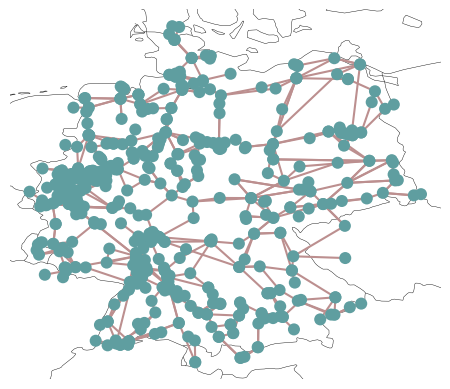

In [4]:
o.plot();

## Solve original nodal market model `o`

First, let us solve a nodal market using the original model `o`:

In [5]:
o.optimize()

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2485 primals, 5957 duals
Objective: 3.01e+05
Solver model

Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-5i9mp0u0 has 5957 rows; 2485 cols; 10948 nonzeros
Coefficient ranges:
  Matrix [1e-02, 2e+02]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [4e-10, 6e+03]
Presolving model
817 rows, 2282 cols, 5248 nonzeros  0s
559 rows, 2017 cols, 4867 nonzeros  0s
535 rows, 1354 cols, 4137 nonzeros  0s
Dependent equations search running on 523 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
523 rows, 1337 cols, 4180 nonzeros  0s
Presolve : Reductions: rows 523(-5434); columns 1337(-1148); elements 4180(-6768)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.2254393827e-01 Pr: 485(2.80835e+06) 0s
        622     3.0120938233e+05 Pr: 0(0); Du: 0(5.32907e-15) 0s
Solving the original LP from the solution after postsolve
M

('ok', 'optimal')

Costs are 301 k€.

## Build market model `m` with two bidding zones

For this example, we split the German transmission network into two market zones at latitude 51 degrees.

You can build any other market zones by providing an alternative mapping from bus to zone. 

In [6]:
zones = (n.buses.y > 51).map(lambda x: "North" if x else "South")

Next, we assign this mapping to the market model `m`.

We re-assign the buses of all generators and loads, and remove all transmission lines within each bidding zone.

Here, we assume that the bidding zones are coupled through the transmission lines that connect them.

In [7]:
for c in m.iterate_components(m.one_port_components):
    c.static.bus = c.static.bus.map(zones)

for c in m.iterate_components(m.branch_components):
    c.static.bus0 = c.static.bus0.map(zones)
    c.static.bus1 = c.static.bus1.map(zones)
    internal = c.static.bus0 == c.static.bus1
    m.remove(c.name, c.static.loc[internal].index)

m.remove("Bus", m.buses.index)
m.add("Bus", ["North", "South"]);

Now, we can solve the coupled market with two bidding zones.

In [8]:
m.optimize()

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1561 primals, 3185 duals
Objective: 2.14e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-0ykuocny has 3185 rows; 1561 cols; 4829 nonzeros
Coefficient ranges:
  Matrix [9e-01, 3e+06]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [4e-10, 3e+04]
Presolving model
40 rows, 1510 cols, 1587 nonzeros  0s
40 rows, 135 cols, 212 nonzeros  0s
Dependent equations search running on 40 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
40 rows, 135 cols, 212 nonzeros  0s
Presolve : Reductions: rows 40(-3145); columns 135(-1426); elements 212(-4617)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -4.3458587374e-04 Pr: 2(51830.2) 0s
         42     2.1398868596e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-0ykuocny
Model status        : Optimal
Si

('ok', 'optimal')

Costs are 214 k€, which is much lower than the 301 k€ of the nodal market.

This is because network restrictions apart from the North/South division are not taken into account yet.

We can look at the market clearing prices of each zone:

In [9]:
m.buses_t.marginal_price

Bus,North,South
snapshot,,
2011-01-01 12:00:00,8.0,25.0


## Build redispatch model `n`

Next, based on the market outcome with two bidding zones `m`, we build a secondary redispatch market `n` that rectifies transmission constraints through curtailment and ramping up/down thermal generators.

First, we fix the dispatch of generators to the results from the market simulation. (For simplicity, this example disregards storage units.)

In [10]:
p = m.generators_t.p / m.generators.p_nom
n.generators_t.p_min_pu = p
n.generators_t.p_max_pu = p

Then, we add generators bidding into redispatch market using the following assumptions:

* All generators can reduce their dispatch to zero. This includes also curtailment of renewables.
* All generators can increase their dispatch to their available/nominal capacity.
* No changes to the marginal costs, i.e. reducing dispatch lowers costs.

With these settings, the 2-stage market should result in the same cost as the nodal market.

In [11]:
g_up = n.generators.copy()
g_down = n.generators.copy()

g_up.index = g_up.index.map(lambda x: x + " ramp up")
g_down.index = g_down.index.map(lambda x: x + " ramp down")

up = (
    as_dense(m, "Generator", "p_max_pu") * m.generators.p_nom - m.generators_t.p
).clip(0) / m.generators.p_nom
down = -m.generators_t.p / m.generators.p_nom

up.columns = up.columns.map(lambda x: x + " ramp up")
down.columns = down.columns.map(lambda x: x + " ramp down")

n.add("Generator", g_up.index, p_max_pu=up, **g_up.drop("p_max_pu", axis=1))

n.add(
    "Generator",
    g_down.index,
    p_min_pu=down,
    p_max_pu=0,
    **g_down.drop(["p_max_pu", "p_min_pu"], axis=1),
);

Now, let's solve the redispatch market:

In [12]:
n.optimize()

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 5331 primals, 11649 duals
Objective: 3.01e+05
Solver mode

Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-tqljvhbi has 11649 rows; 5331 cols; 19486 nonzeros
Coefficient ranges:
  Matrix [1e-02, 2e+02]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [2e-19, 6e+03]
Presolving model
817 rows, 2285 cols, 5251 nonzeros  0s
560 rows, 2020 cols, 4873 nonzeros  0s
539 rows, 1358 cols, 4149 nonzeros  0s
Dependent equations search running on 527 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
527 rows, 1341 cols, 4192 nonzeros  0s
Presolve : Reductions: rows 527(-11122); columns 1341(-3990); elements 4192(-15294)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        620     3.0120938233e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-

('ok', 'optimal')

And, as expected, the costs are the same as for the nodal market: 301 k€.

Now, we can plot both the market results of the 2 bidding zone market and the redispatch results:

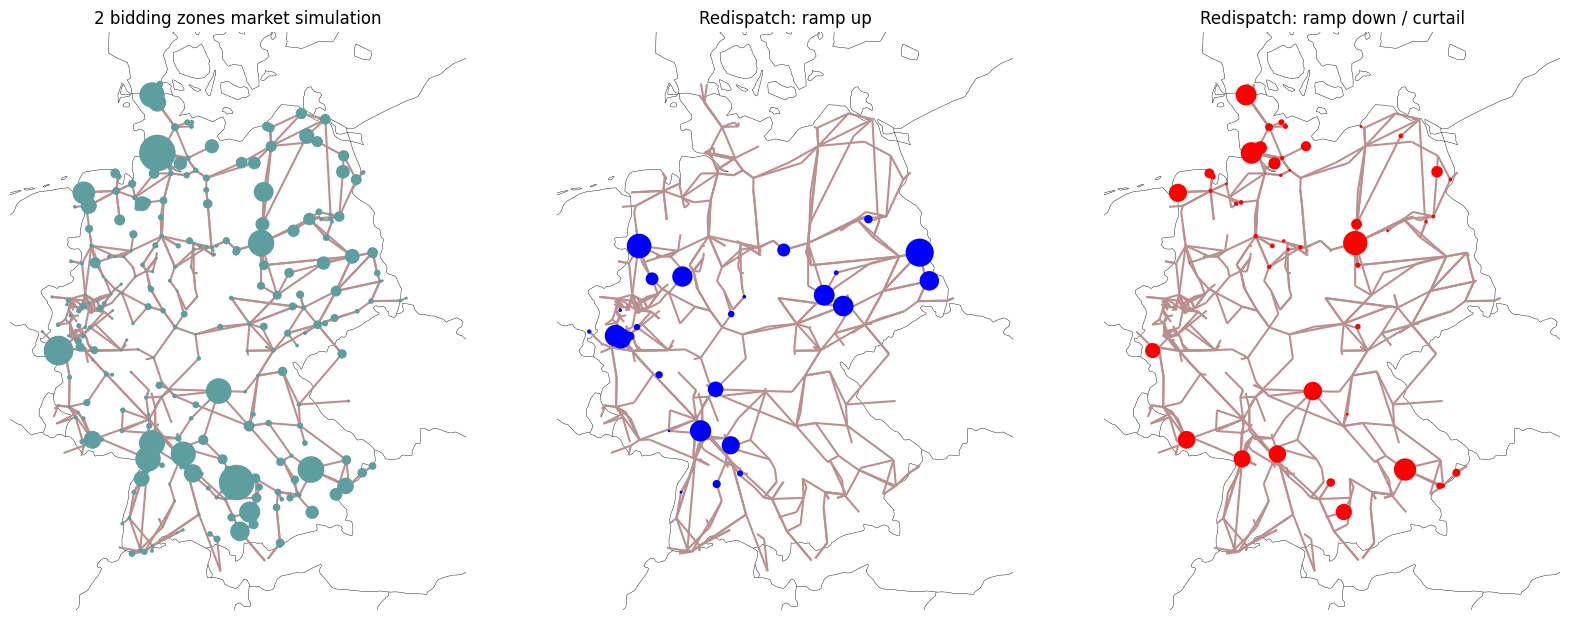

In [13]:
fig, axs = plt.subplots(
    1, 3, figsize=(20, 10), subplot_kw={"projection": ccrs.AlbersEqualArea()}
)

market = (
    n.generators_t.p[m.generators.index]
    .T.squeeze()
    .groupby(n.generators.bus)
    .sum()
    .div(2e4)
)
n.plot(ax=axs[0], bus_sizes=market, title="2 bidding zones market simulation")

redispatch_up = (
    n.generators_t.p.filter(like="ramp up")
    .T.squeeze()
    .groupby(n.generators.bus)
    .sum()
    .div(2e4)
)
n.plot(
    ax=axs[1], bus_sizes=redispatch_up, bus_colors="blue", title="Redispatch: ramp up"
)

redispatch_down = (
    n.generators_t.p.filter(like="ramp down")
    .T.squeeze()
    .groupby(n.generators.bus)
    .sum()
    .div(-2e4)
)
n.plot(
    ax=axs[2],
    bus_sizes=redispatch_down,
    bus_colors="red",
    title="Redispatch: ramp down / curtail",
);

We can also read out the final dispatch of each generator:

In [14]:
grouper = n.generators.index.str.split(" ramp", expand=True).get_level_values(0)

n.generators_t.p.groupby(grouper, axis=1).sum().squeeze()

/tmp/ipykernel_23617/2204001103.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



1 Gas                     0.000000
1 Hard Coal               0.000000
1 Solar                  11.326192
1 Wind Onshore            1.754382
100_220kV Solar          14.913326
                           ...    
98 Wind Onshore          71.451646
99_220kV Gas              0.000000
99_220kV Hard Coal        0.000000
99_220kV Solar            8.246606
99_220kV Wind Onshore     3.432939
Name: 2011-01-01 12:00:00, Length: 1423, dtype: float64

## Changing bidding strategies in redispatch market

We can also formulate other bidding strategies or compensation mechanisms for the redispatch market.

For example, that ramping up a generator is twice as expensive.

In [15]:
n.generators.loc[n.generators.index.str.contains("ramp up"), "marginal_cost"] *= 2

Or that generators need to be compensated for curtailing them or ramping them down at 50% of their marginal cost.

In [16]:
n.generators.loc[n.generators.index.str.contains("ramp down"), "marginal_cost"] *= -0.5

In this way, the outcome should be more expensive than the ideal nodal market:

In [17]:
n.optimize()

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.1s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 5331 primals, 11649 duals
Objective: 4.99e+05
Solver model

Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-tp_8pkw3 has 11649 rows; 5331 cols; 19486 nonzeros
Coefficient ranges:
  Matrix [1e-02, 2e+02]
  Cost   [2e+00, 2e+02]
  Bound  [0e+00, 0e+00]
  RHS    [2e-19, 6e+03]
Presolving model
817 rows, 2277 cols, 5243 nonzeros  0s
558 rows, 2004 cols, 4855 nonzeros  0s
536 rows, 1350 cols, 4138 nonzeros  0s
Dependent equations search running on 524 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
524 rows, 1333 cols, 4181 nonzeros  0s
Presolve : Reductions: rows 524(-11125); columns 1333(-3998); elements 4181(-15305)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        628     4.9929741194e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-

('ok', 'optimal')

Costs are now 502 k€ compared to 301 k€.